# Objectives

1. Filter Outlier Tips
1. Estimate a Clock Model
1. Add Clock Model to Dataframe

---
# Setup

## Modules

In [19]:
import treetime
import sys
from Bio import Phylo
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import pandas as pd
import dill


## Paths

In [49]:
tree_df_path = "../../docs/results/latest/parse_tree/parse_tree.tsv"
tree_df_dill = "../../docs/results/latest/parse_tree/parse_tree.df.obj"
tree_path = "../../docs/results/latest/parse_tree/parse_tree.nwk"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"

auspice_latlon_path = "../../docs/results/latest/parse_tree/parse_tree_latlon.tsv"
auspice_config_path = "../../config/auspice_config.json"
auspice_colors_path = "../../docs/results/latest/parse_tree/parse_tree_colors.tsv"
auspice_remote_dir_path = "../../auspice/"

outdir = "../../docs/results/latest/clock_model"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [52]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "clock_model"

## Import Tree

In [5]:
tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Dataframe

In [8]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# 1. Filter Outlier Tips

## Parse Tip Dates

In [15]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v
        
# Add Reference
dates["Reference"] = REF_DATE


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


## Filter

In [16]:
# Initialize stdout capture
# print("Starting clock filtering...")
# old_stdout = sys.stdout
# new_stdout = io.StringIO()
# sys.stdout = new_stdout

clock_filter_dict = {"pre" : [], "post": []}
# A boolean to decide if we keep running the clock_filter
has_bad_branches = True

# Keep calculating and collapsing until no bad_branches
while has_bad_branches:
    # Construct the treetime object
    # Remember, including the alignment is crucial!
    tt = treetime.TreeTime(dates=dates, 
                           aln=aln_path,                     
                           tree=tree, 
                           verbose=4, 
                           fill_overhangs=False,
                           seq_len=REF_LEN,                        
                          )

    # Remove outliers
    tt.clock_filter(reroot=None, 
                    n_iqd=N_IQD, 
                    plot=False,
                    )
        
    # Check rtt
    print("Clock Model: ", tt.date2dist.__dict__)
    has_bad_branches = True in [c.bad_branch for c in tt.tree.find_clades()]
    
    if has_bad_branches:
        # Color the bad clades red
        bad_clades = []
        bad_nodes = []
        for c in tt.tree.find_clades():
            if c.bad_branch:
                bad_clades.append(c.name)
                c.color = "red"
                
        # Store the pre tree
        clock_filter_dict["pre"].append(copy.deepcopy(tt))                
                
        # Collapse bad ckades
        for b in bad_clades:
            # Possibly already collapsed if redundancy
            try:
                b_node = tt.tree.common_ancestor([b])
                for c in b_node.find_clades():
                    # Add to the list of bad nodes
                    bad_nodes.append(c)
                    tt.tree.collapse(target=c.name)
                    print("Collapsed node {} in the tree.".format(c))
            except ValueError:
                continue
        
        # Remove from dataframe
        for b in bad_clades:
            try:
                tree_df.drop(index=b, inplace=True)
                print("Dropped {} from the dataframe.".format(b))
            except KeyError:
                continue
        
        # Store the post tree
        clock_filter_dict["post"].append(copy.deepcopy(tt))
        
# Save stdout to file
# output = new_stdout.getvalue()
# out_path = os.path.join(outdir, SCRIPT_NAME + "_clock_filter.log") 
# with open(out_path, "w") as file:
#     file.write(output)
# # Restore stdout
# sys.stdout = old_stdout
# print("Standard output restored, logging to file disabled.")


0.00	-TreeAnc: set-up

1.18	-SequenceData: loaded alignment.
1.18	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.18	-SeqData: making compressed alignment...

3.97	-SequenceData: constructed compressed alignment...
4.30	--ClockTree: Setting precision to level 2

4.39	-ClockTree._assign_dates: assigned date contraints to 634 out of 634 tips.
4.73	--ClockTree.date2dist: Setting new molecular clock. rate=9.508e-09,
    	  R^2=0.2300
4.75	---TreeTime.ClockFilter: marking GCA_008630375.1_ASM863037v1_genomic as
    	   outlier, residual 3.979261 interquartile distances
4.75	---TreeTime.ClockFilter: marking GCA_008630375.2_ASM863037v2_genomic as
    	   outlier, residual 4.261789 interquartile distances
4.75	---TreeTime.ClockFilter: marking GCA_003086075.1_ASM308607v1_genomic as
    	   outlier, residual 3.010350 interquartile distances
4.75	---TreeTime.ClockFilter: marking GCA_001613865.1_ASM161386v1_genomic as
 

## Plot

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/treetime/treeregression.py:561: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
No handles with labels found to put in legend.


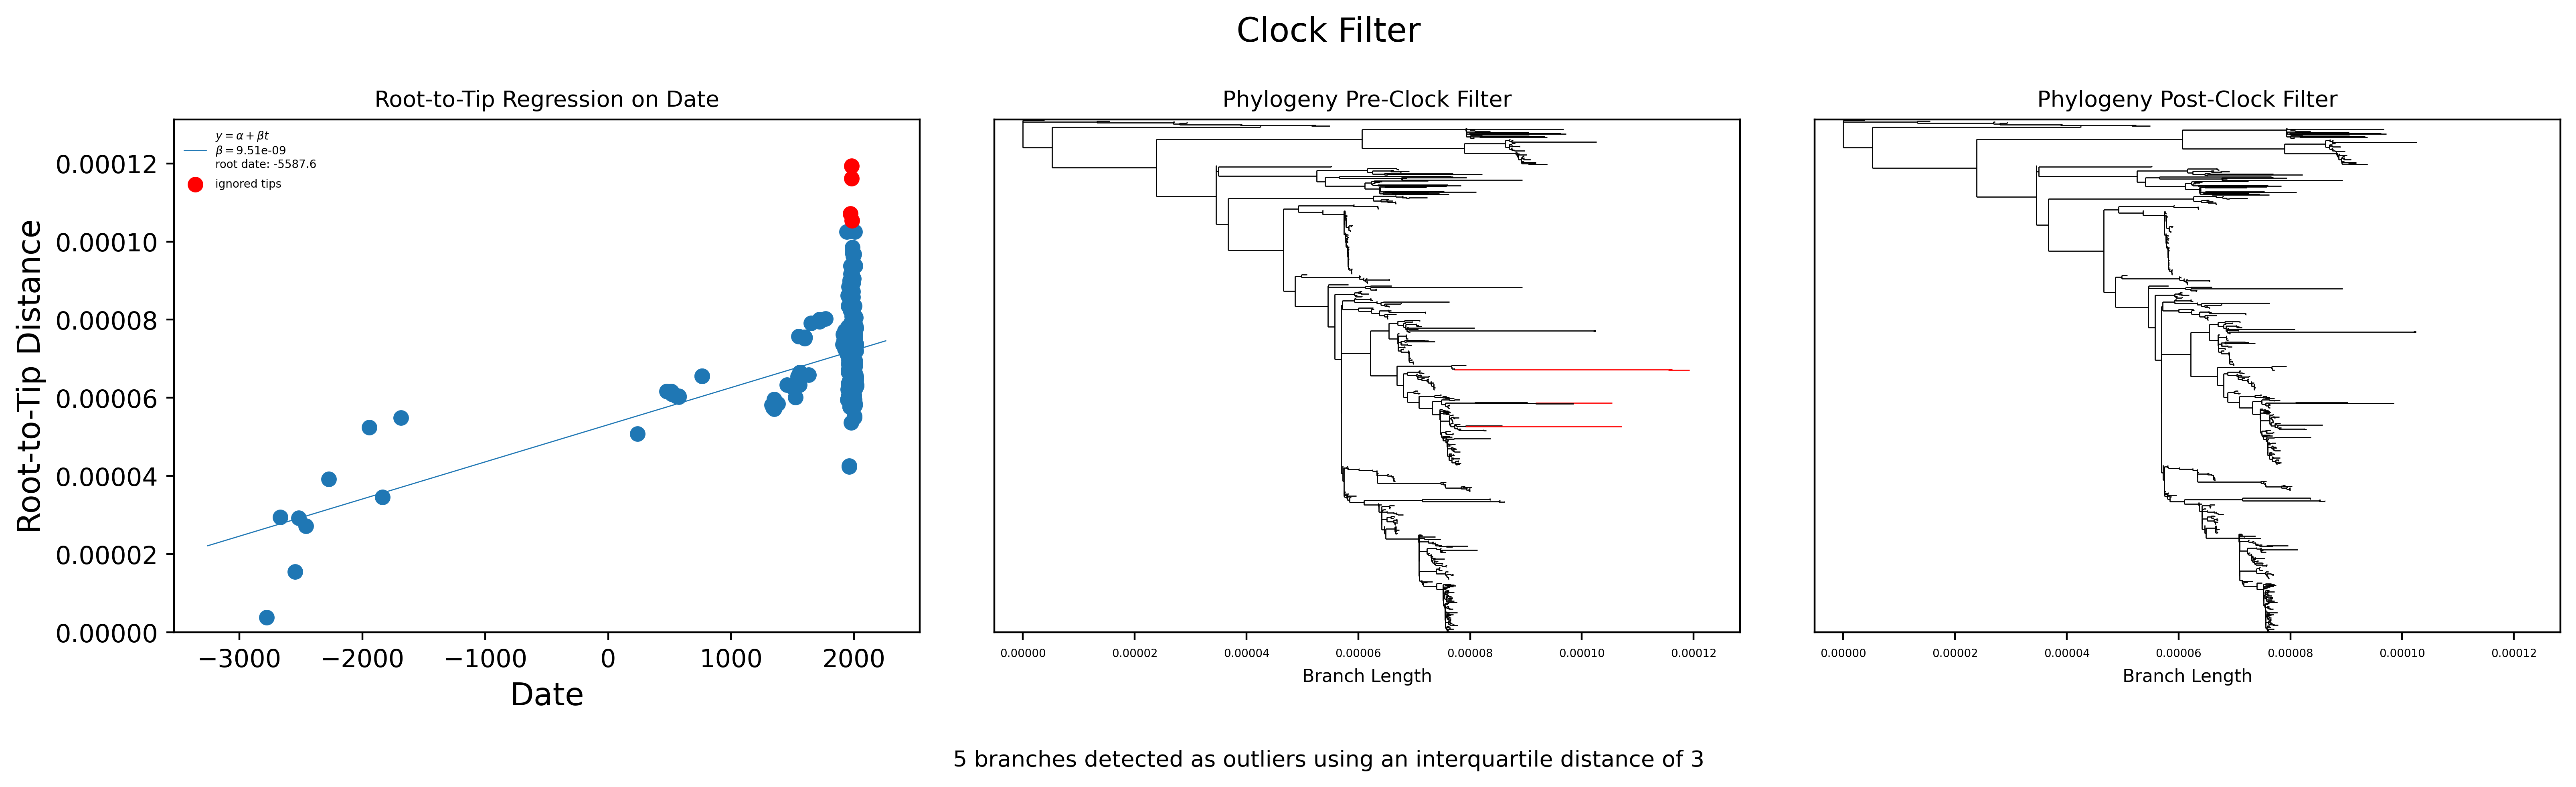

In [24]:
# Count the iterations needed
iter = 0

for pre, post in zip(clock_filter_dict["pre"], clock_filter_dict["post"]):
    iter += 1

    # Setup the figure
    fig = plt.figure(dpi=dpi,
                     figsize=(figsize[0] * 3, figsize[1] * 3),
                     )
    
    # Setup the grid
    gs = gridspec.GridSpec(3, 3, figure=fig, wspace=0.1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2],sharex=ax2)    
    
    # -----------------------------------------------------
    # Axis 1: Root To Tip Regression
    pre.plot_root_to_tip(add_internal=False, label=True, ax=ax1)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Root-to-Tip Distance")
    ax1.set_title("Root-to-Tip Regression on Date")
    ax1.legend()

    # -----------------------------------------------------
    # Axis 2: Phylogeny Pre Clock Filter
    for c in pre.tree.find_clades():
        if c.bad_branch:
            c.color = "red"

    print("drawing pre tree")
    Phylo.draw(pre.tree, 
            show_confidence=False, 
            label_func = lambda x: '',
            do_show=False,
            axes=ax2)
    
    # Labels
    ax2.set_xlabel("Branch Length")
    ax2.set_yticks([])
    ax2.set_ylabel('')
    ax2.set_title("Phylogeny Pre-Clock Filter")
    
    
    # -----------------------------------------------------
    # Axis 3: Phylogeny Post Clock Filter
    print("drawing post tree")
    Phylo.draw(post.tree, 
            show_confidence=False, 
            label_func = lambda x: '',
            do_show=False,
            axes=ax3)
    ax3.set_xlabel("Branch Length")
    ax3.set_yticks([])
    ax3.set_ylabel('')
    ax3.set_title("Phylogeny Post-Clock Filter")
    
    # -----------------------------------------------------
    # Title
    plt.suptitle("Clock Filter", y=0.925, fontsize=15)

    # -----------------------------------------------------
    # Caption
    num_bad_branches = [c.bad_branch for c in pre.tree.find_clades()].count(True)
    caption_text = ("{} branches detected as outliers using an interquartile distance of {}".format(num_bad_branches, N_IQD)                               )
    fig.text(0.5, 0.6, caption_text, ha='center', fontsize=10)
    
    # -----------------------------------------------------
    # Save
    out_path = os.path.join(outdir, SCRIPT_NAME + "_filter_{}.".format(iter) + FMT) 
    plt.savefig(out_path, dpi=dpi)

---
# 2. Estimate Clock Model

In [25]:
tt.run()
tt.tree.ladderize(reverse=False)


382.21	-TreeTime._set_branch_length_mode: maximum branch length is 3.716e-05,
      	 using branch length mode joint

382.21	-TreeAnc.optimize_tree: sequences...

382.21	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

382.21	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences
      	of tips at positions with AMBIGUOUS bases. This resulted in unexpected
      	behavior is some cases and is no longer done by default. If you want to
      	replace those ambiguous sites with their most likely state, rerun with
      	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
382.21	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
382.21	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
388.70	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
      	   likelihood sequences...
388.97	---TreeAnc._ml_anc_joint: ...done
388.99	--TreeAnc.infer_gtr: counting mutations...
390.63	---TreeAnc.infer_gtr: counting

'success'

In [29]:
# Quick Check #1
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch=2.148814885614286e-07, branch_length=0.0, clock_length=0.0, date='-4135-10-13', dist2root=0.0, mutation_length=0.0, name='NODE0', original_length=0.0)

---
# 3. Add Clock Model to Dataframe

- Rates
- Dates
- RTT Regression
- Skyline

## Rates

In [30]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [40]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    tree_df["timetree_num_date_confidence"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    
HAS_MARGINAL = False
# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):   
        # Set the boolean flag on the first time encountered
        if not HAS_MARGINAL:
            HAS_MARGINAL = True
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length

799.36	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


## RTT

In [42]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

823.84	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.97532e-09,1,0,-4135-10-13,-4134.22,0.1,0.1,17.9492,-4134.22,0,False
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,8.97532e-09,1,3.22495e-06,-2876-01-01,-2876,1258.22,1258.32,1,-2776.5,3.22495e-06,False
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.97532e-09,1,7.74576e-06,-3477-02-05,-3476.9,657.316,657.416,3.15625,-3476.9,7.74576e-06,False
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,8.97532e-09,1,1.93515e-06,-2621-01-01,-2621,855.902,1513.32,2,-2546.5,9.68091e-06,False
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.97532e-09,1,1.42177e-05,-2720-09-22,-2719.27,757.627,1415.04,4.3125,-2719.27,2.19635e-05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1,8.97532e-09,1,2.14887e-07,2010-01-01,2010,58.0585,6144.32,624,2010,6.8423e-05,False
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.97532e-09,1,2.14897e-07,1969-10-09,1969.77,17.8308,6104.09,629.5,1969.77,6.84231e-05,False


## Skyline

In [48]:
if hasattr(tt, "merger_model"):
    #skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=N_STD)
    #print(skyline)
    #print(conf)
    out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
    out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )
    treetime.wrappers.print_save_plot_skyline(tt, 
                                              plot=out_path_skyline_pdf, 
                                              save=out_path_skyline_txt,
                                              screen=True,
                                              n_std=2.0, )

---
# Export

## Tree and Dataframe

In [44]:
# Save tree dataframe with clock info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)
    
# Save timetree trees
out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
out_path_pickle_tree = os.path.join(outdir,  SCRIPT_NAME + ".treetime.obj" )


Phylo.write(tt.tree, out_path_xml, 'phyloxml')
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
with open(out_path_pickle_tree,"wb") as outfile:
    dill.dump(tt, outfile)

## Augur JSON

In [46]:
augur_dict = augur_export(
    tree_path=tree_path, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
    augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8768e-06, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'rate': 8.975324211796821e-09, 'rate_fold_change': 1.0, 'mutation_length': 1.7201744983700798e-06, 'raw_date': '1992-01-01', 'num_date': 1992.0, 'clock_length': 43.896183411389075}


## Auspice JSON

In [50]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

Validating schema of '../../config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '../../docs/results/latest/clock_model/clock_model_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '../../docs/results/latest/clock_model/clock_model_auspice.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '../../auspice/plague-phylogeography_clock-model.json'...
Validating that the JSON is internally consistent...
Validation of '../../auspice/plague-phylogeography_clock-model.json' succeeded.
Validation successful for remote JSON.
